# Training and diagnosing

SKLearn contains implementations for a great range of machine learning algorithms. When possible, you should use these instead of programming these algorithms yourself. These implemenations have been tested to work well under varying circumstances, are often programmed more optimally than we would be able to, contain many extensions and variants that you can readily try out, are well documented and often base their implementation on scientific literature in which the algorithms are described, and deliver results that are more reproducible for others!

The caveat is that most models can be configured via so-called hyperparameters: e.g. decision trees need a maximum depth, gradient descent needs a learning rate or stopping criterium. The most easy way to train these models is to simply call the `fit` method. But if we can use different cnfigurations, how do we know if we obtained the best possible results?

For standard hyperparameters, we will discuss their 'tuning' later on. Most specifically, gradient descent needs special care to ensure optimal results and avoid so-called underfitting and overfitting. This special care can be given by diagnosing the learning process. For this, it is necessary to train in a loop ad monitor loss, rather than using the `fit` method.

We will show this by learning a 2nd order polynomial regression line on the dam dataset.

In [132]:
from ml import *
data = dam(degree=2, scale=True)

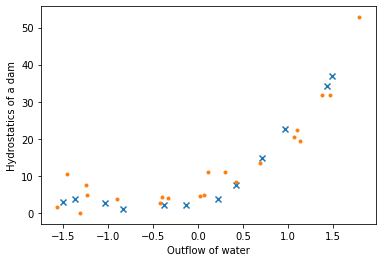

In [133]:
data.plot(marker = 'x')
data.plot_valid(marker = '.')

To diagnose the learning process, we need to write a `train` loop that repeatedly passes over the training set. Every step, the model is updated (hopefully improved) and the loss s computed and stored in a List. Then a `plot` function draws the 'learning curve'.

In [134]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from statistics import stdev

def loss(model, X, y):
    pred_y = model.predict(X)
    loss = math.sqrt(mean_squared_error(y, pred_y))
    return loss

def train(model, n=100):
    ''' 
    train the model for n steps, using data.train_X and data.train_y
    returns a list of losses for each step
    '''
    train_loss = []
    valid_loss = []
    for _ in range(n):
        # learn a single pass over the training set
        model.partial_fit(data.train_X, data.train_y)
        
        # compute the loss over the training and validation set 
        train_loss.append( loss(model, data.train_X, data.train_y) )
        valid_loss.append( loss(model, data.valid_X, data.valid_y) )

    return train_loss, valid_loss

def plot(losses):
    '''
    plot the learning curve from the list of losses collected during training
    '''
    x = list(range(len(losses))) # generate iteration numbers
    ymax = sum(losses) / len(losses) + 2 * stdev(losses)
    plt.ylim(0, ymax)   # trick to avoid overly high values from making the graph unreadable
    plt.plot(x, losses)

Now let's see the difference between a learning rate of  0.3, 0.1, 0.03 and 0.01

As we can see below, 0.3 overshoots

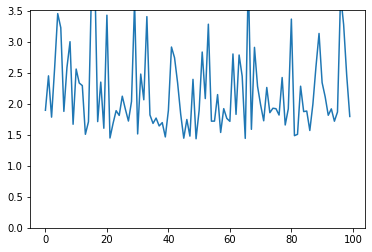

In [135]:
model = SGDRegressor(eta0=0.3, learning_rate='constant', penalty=None)
train_loss, _ = train(model)
plot(train_loss)

0.1 converges a bit better, but overshoots near the optimum.

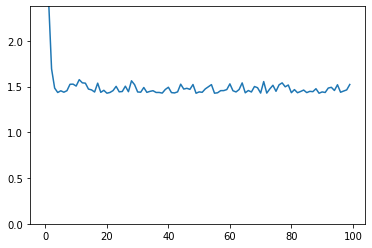

In [136]:
model = SGDRegressor(eta0=0.1, learning_rate='constant', penalty=None)
train_loss, _ = train(model)
plot(train_loss)

0.03 delivers a smooth learning curve

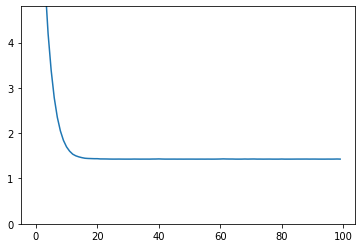

In [137]:
model = SGDRegressor(eta0=0.03, learning_rate='constant', penalty=None)
train_loss, _ = train(model)
plot(train_loss)

0.01 also delivers a smooth learning curve, but is slower to learn. Therefore, a learning rate of 0.03 works best on this dataset with this model. 

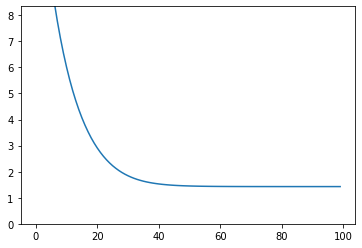

In [138]:
model = SGDRegressor(eta0=0.01, learning_rate='constant', penalty=None)
train_loss, _ = train(model)
plot(train_loss)

0.003 also delivers a smooth learning curve, but is slower to learn. Therefore, a learning rate of 0.03 or 0.01 works best on this dataset with this model.

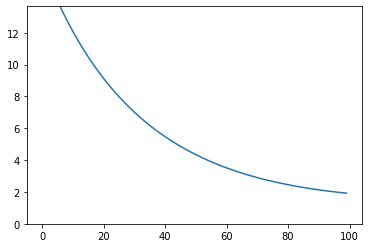

In [139]:
model = SGDRegressor(eta0=0.003, learning_rate='constant', penalty=None)
train_loss, _ = train(model)
plot(train_loss)

What is the best moment to stop learning? It may seem that is the case when the training loss approaches the minimum, but it often is not. In the latest stage, the model may slightly overfit on the exact position of the training items. We can view this effect by looking at an set of data points that was not used during training. We will call such a set the validation set, and there is one already present in the data object. Because the validation set is not used to train on, this will give us an estimation of the prediction on unseen data.

As we can see in the example below, the validation curve bottoms out before the trainig curve. In fact, after that point, we usually see the training loss improving slightly while the validation loss slightly degrades. This is because the model slightly overfits on the training examples. Arguably, a good termination point is when the validation curve reaches its minimum.

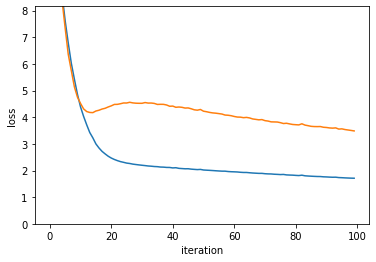

In [148]:
model = SGDRegressor(eta0=0.01, learning_rate='constant', penalty=None)
train_loss, valid_loss = train(model)
plt.ylabel('loss')
plt.xlabel('iteration')
plot(train_loss)
plot(valid_loss)

# Hyperparameter tuning

Now let's do it diffently. Let's say that we wish to decide what the best complexity for the model is. We will try order 1-10 polynomials and simply use the loss when each model reaches its minimum validation loss.

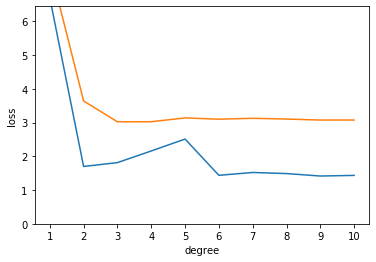

In [151]:
train_losses, valid_losses = [], []
for degree in range(1, 11):
    data = dam(degree=degree, scale=True)
    model = SGDRegressor(eta0=0.03, learning_rate='constant', penalty=None)
    tl, vl = train(model, 1000)
    vl, tl = min([ (v, t) for v, t in zip(vl, tl)])
    train_losses.append(tl)
    valid_losses.append(vl)

plt.xticks(range(0,10), range(1, 11)) # change the labels on the x-axis
plt.ylabel('loss')
plt.xlabel('degree')
plot(train_losses)
plot(valid_losses)

And so it appears that a 3rd or 4th order polynomial is best. At least, from this diagnosis. In another experiment, we have seen that fourth order polynomials may not extrapolate well.